# 📊 Performance Benchmarking System
## Comprehensive Model Analysis & Performance Metrics

[![Benchmarking](https://img.shields.io/badge/Stage-Performance%20Benchmarking-green?logo=chartdotjs&logoColor=white)]()
[![Multi-Model](https://img.shields.io/badge/Support-Multi%20Model-purple)]()
[![ONNX Compatible](https://img.shields.io/badge/ONNX-Compatible-blue)]()

---

### 📋 Overview

This notebook provides comprehensive benchmarking of all trained models and integrates seamlessly at the end of your ML pipeline. It automatically discovers models and provides detailed performance analysis.

### 🎯 Key Features

- **🔍 Automatic Discovery**: Finds all available models including fine-tuned variants
- **⚙️ Configuration Inheritance**: Uses existing pipeline configuration with intelligent fallbacks
- **🔀 Comparative Analysis**: Benchmarks original models vs. fine-tuned versions
- **📊 Result Integration**: Combines with explainability and fine-tuning results

### 📈 Benchmarking Metrics

- **⚡ Latency**: Inference time per sample (ms)
- **🚀 Throughput**: Samples processed per second
- **💾 Memory Usage**: Peak memory consumption during inference
- **🎯 Accuracy**: Model performance on test datasets
- **📊 Model Size**: Disk footprint and parameter count

### 🏗️ Supported Model Formats

| Format | Optimisations | Quantisation | Notes |
|--------|--------------|--------------|-------|
| **PyTorch** | Standard | None | Original trained models |
| **ONNX** | Graph-level | FP16/INT8 | Optimised for inference |
| **Fine-tuned** | Task-specific | Variable | Enhanced performance models |

### 🖥️ Hardware Analysis

- **CPU Performance**: Multi-core utilisation analysis
- **GPU Acceleration**: CUDA/MPS performance metrics
- **Memory Profiling**: RAM and VRAM usage patterns
- **Cross-platform**: Windows, macOS, Linux compatibility

### 📁 Output Structure

```
results/
├── benchmark_results.csv      # Detailed metrics
├── performance_comparison.png # Visualisations
├── benchmarking_report.html  # Interactive report
└── model_rankings.json       # Performance rankings
```

---

**🚀 Quick Start**: Simply run all cells - the notebook automatically discovers your models and applies appropriate configurations!

In [ ]:
# Import configuration system and benchmarking utilities
import sys
import os
sys.path.append("../")

# Check if we're running at the end of the pipeline and initialise accordingly
from pathlib import Path

try:
    from src.pipeline_utils import ConfigManager, StateManager, LoggingManager
    pipeline_available = True
except ImportError:
    print("⚠️ Pipeline utilities not available. Running in standalone mode.")
    pipeline_available = False
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import time
import gc
import platform
from typing import Dict, List, Optional, Tuple, Any
from dataclasses import dataclass, asdict
from collections import defaultdict
import warnings

# Machine Learning imports
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ONNX and optimisation imports
try:
    import onnxruntime as ort
    onnx_available = True
except ImportError:
    print("⚠️ ONNXRuntime not installed. Install with: pip install onnxruntime")
    onnx_available = False

# Hugging Face transformers
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import pickle
    transformers_available = True
except ImportError:
    print("⚠️ Transformers not installed")
    transformers_available = False

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Resource control imports
import psutil

# Initialise managers with fallback configuration
if pipeline_available:
    # Load from existing pipeline configuration
    config = ConfigManager("../config/pipeline_config.json")
    state = StateManager("../config/pipeline_state.json")
    logger_manager = LoggingManager(config, 'benchmarking')
    logger = logger_manager.get_logger()
    print("✅ Pipeline configuration loaded")
else:
    # Standalone configuration for end-of-pipeline usage
    class SimpleConfig:
        def __init__(self):
            # Default configuration for benchmarking
            self.data = {
                'models': {'output_dir': 'models'},
                'data': {'processed_data_dir': 'data/processed'},
                'benchmarking': {
                    'fast_mode': True,
                    'target_models': [],
                    'exclude_models': [],
                    'include_accuracy': True,
                    'iterations': {'fast': 15, 'thorough': 30},

2025-08-18 10:46:19,867 - pipeline.benchmarking - INFO - 📊 Starting Performance Benchmarking - Generalized Pipeline


✅ Pipeline configuration loaded
💡 No explainability fine-tuned model found (run explainability notebook first)
💡 No comparative fine-tuning results found
🔧 Resource limits applied:
   🖥️ CPU threads: 2
   💾 Available memory: 1.1GB
📋 Configuration loaded from ../config/pipeline_config.json


In [2]:
# Benchmarking Data Structures and Configuration
@dataclass
class BenchmarkResult:
    """Structured class to hold results from a single benchmark run."""
    model_name: str
    model_type: str  # 'pytorch' or 'onnx'
    batch_size: int
    avg_latency_ms: float
    p50_latency_ms: float
    p95_latency_ms: float
    p99_latency_ms: float
    throughput_samples_per_sec: float
    peak_memory_mb: float
    model_size_mb: float
    provider: str
    accuracy: Optional[float] = None
    f1_score: Optional[float] = None
    weighted_accuracy: Optional[float] = None
    weighted_f1_score: Optional[float] = None
    avg_confidence_correct: Optional[float] = None
    avg_confidence_incorrect: Optional[float] = None
    per_class_metrics: Optional[Dict] = None
    validation_samples: Optional[int] = None
    
    # Enhanced metrics
    std_latency_ms: Optional[float] = None
    min_latency_ms: Optional[float] = None
    max_latency_ms: Optional[float] = None
    avg_memory_mb: Optional[float] = None
    memory_overhead_mb: Optional[float] = None
    efficiency_score: Optional[float] = None  # throughput / model_size_mb
    latency_stability: Optional[float] = None  # coefficient of variation (lower is better)
    memory_efficiency: Optional[float] = None  # throughput / peak_memory_mb
    
    def to_dict(self) -> Dict:
        """Convert to dictionary with flattened per-class metrics."""
        flat_dict = asdict(self)
        per_class = flat_dict.pop("per_class_metrics", {})
        if per_class:
            for class_name, metrics in per_class.items():
                for metric_name, value in metrics.items():
                    flat_dict[f"{class_name}_{metric_name}"] = value
        
        # Calculate derived metrics
        if flat_dict.get('throughput_samples_per_sec') and flat_dict.get('model_size_mb'):
            flat_dict['efficiency_score'] = flat_dict['throughput_samples_per_sec'] / flat_dict['model_size_mb']
        if flat_dict.get('std_latency_ms') and flat_dict.get('avg_latency_ms'):
            flat_dict['latency_stability'] = flat_dict['std_latency_ms'] / flat_dict['avg_latency_ms']  # CV
        if flat_dict.get('throughput_samples_per_sec') and flat_dict.get('peak_memory_mb') and flat_dict['peak_memory_mb'] > 0:
            flat_dict['memory_efficiency'] = flat_dict['throughput_samples_per_sec'] / flat_dict['peak_memory_mb']
            
        return flat_dict

class ExecutionProviderManager:
    """Manages ONNX execution providers for consistent benchmarking."""
    
    @staticmethod
    def get_execution_providers() -> List[str]:
        """Get available execution providers for benchmarking (CPU only to avoid issues)."""
        # Only use CPU provider to prevent CoreML errors and reduce resource usage
        return ['CPUExecutionProvider'] if onnx_available else []

# Load benchmarking configuration
benchmark_config = config.get('benchmarking', {})
models_config = config.get('models', {})
data_config = config.get('data', {})

# Resource-aware configuration - All settings loaded from config file
FAST_MODE = benchmark_config.get('fast_mode', True)
TARGET_MODELS = benchmark_config.get('target_models', [])  # Load from config, fallback to empty list (test all models)
EXCLUDE_MODELS = benchmark_config.get('exclude_models', [])  # Load from config, fallback to empty list (exclude none)
INCLUDE_ACCURACY = benchmark_config.get('include_accuracy', True)  # Enable accuracy by default for better insights

print("📊 Benchmarking Configuration:")
print(f"   ⚡ Fast mode: {FAST_MODE}")
print(f"   🎯 Target models: {TARGET_MODELS if TARGET_MODELS else 'All available models'}")
print(f"   ❌ Excluded models: {EXCLUDE_MODELS if EXCLUDE_MODELS else 'None'}")
print(f"   🔧 CPU threads limited to: {MAX_CPU_THREADS}")
print(f"   📊 Include accuracy: {INCLUDE_ACCURACY}")

# Performance parameters - Resource-optimized for development environment

# Performance parameters - Resource-optimized for development environment
if FAST_MODE:
    ITERATIONS = benchmark_config.get('iterations', {}).get('fast', 15)  # Increased for better precision
    WARMUP_ITERATIONS = benchmark_config.get('warmup_iterations', {}).get('fast', 5)  # Increased warmup
    BATCH_SIZES = benchmark_config.get('batch_sizes', {}).get('fast', [1, 4])  # Reduced batch sizes
    ACCURACY_SAMPLE_SIZE = benchmark_config.get('accuracy_sample_size', {}).get('fast', 500)  # Increased for better accuracy measurement
else:
    ITERATIONS = benchmark_config.get('iterations', {}).get('thorough', 30)  # Increased for precision
    WARMUP_ITERATIONS = benchmark_config.get('warmup_iterations', {}).get('thorough', 10)  # More warmup
    BATCH_SIZES = benchmark_config.get('batch_sizes', {}).get('thorough', [1, 4, 8])  # Reduced batch sizes
    ACCURACY_SAMPLE_SIZE = benchmark_config.get('accuracy_sample_size', {}).get('thorough', 1000)  # Large sample for thorough mode

print(f"   🔄 Iterations: {ITERATIONS} (warmup: {WARMUP_ITERATIONS})")
print(f"   📊 Batch sizes: {BATCH_SIZES}")
print(f"   🎯 Accuracy samples: {ACCURACY_SAMPLE_SIZE if INCLUDE_ACCURACY else 'Disabled'}")

logger.info("Benchmarking configuration loaded successfully")

2025-08-18 10:46:19,908 - pipeline.benchmarking - INFO - Benchmarking configuration loaded successfully


📊 Benchmarking Configuration:
   ⚡ Fast mode: True
   🎯 Target models: ['tinybert-financial-classifier', 'tinybert-financial-classifier-fine-tuned', 'tinybert-financial-classifier_explainability_fine_tuned', 'distilbert-financial-sentiment', 'distilbert-financial-sentiment-pruned']
   ❌ Excluded models: ['SmolLM2-360M-Instruct-financial-sentiment', 'all-MiniLM-L6-v2-financial-sentiment', 'finbert-tone-financial-sentiment']
   🔧 CPU threads limited to: 2
   📊 Include accuracy: True
   🔄 Iterations: 15 (warmup: 5)
   📊 Batch sizes: [1, 4]
   🎯 Accuracy samples: 500


## 🔧 Configuration-Driven Benchmarking

All benchmarking parameters are now loaded from `../config/pipeline_config.json` under the `benchmarking` section:

- **`target_models`**: Specify which models to benchmark (empty list = test all available models)
- **`exclude_models`**: Models to explicitly exclude from benchmarking  
- **`fast_mode`**: Toggle between fast and thorough benchmarking modes
- **`include_accuracy`**: Enable/disable accuracy evaluation during benchmarking
- **`iterations`** & **`warmup_iterations`**: Control precision vs. speed trade-off
- **`batch_sizes`**: Batch sizes to test for each model
- **`accuracy_sample_size`**: Number of samples for accuracy evaluation

**Validation Data**: Uses actual datasets from `../data/processed/validation.csv` or `../data/FinancialPhraseBank/all-data.csv` for realistic accuracy measurements.

This approach makes it easy to customize benchmarking without code changes!

In [3]:
# Model Discovery and Loading
logger.info("🔍 Discovering available models...")

# Verify prerequisites
if not onnx_available or not transformers_available:
    raise ImportError("Required libraries missing. Install with: pip install onnxruntime transformers")

# Check if ONNX conversion was completed
onnx_conversion_completed = True  # Default to True for end-of-pipeline usage
if pipeline_available and state and hasattr(state, 'is_step_complete'):
    if not state.is_step_complete('onnx_conversion_completed'):
        print("⚠️ ONNX conversion not completed. ONNX benchmarks will be skipped.")
        onnx_conversion_completed = False
    else:
        onnx_conversion_completed = True
else:
    print("💡 Checking for ONNX models directly...")
    # Check if any ONNX models exist
    models_dir = Path(f"../{config.get('models', {}).get('output_dir', 'models')}")
    if models_dir.exists():
        onnx_found = any((model_dir / 'onnx').exists() and list((model_dir / 'onnx').glob('*.onnx')) 
                        for model_dir in models_dir.iterdir() if model_dir.is_dir())
        if not onnx_found:
            print("⚠️ No ONNX models found. ONNX benchmarks will be skipped.")
            onnx_conversion_completed = False

models_dir = Path(f"../{models_config.get('output_dir', 'models')}")
print(f"📂 Models directory: {models_dir}")

# Discover available models
available_models = {}

if models_dir.exists():
    for model_path in models_dir.iterdir():
        if not model_path.is_dir() or model_path.name.startswith('.'):
            continue
            
        model_name = model_path.name
        
        # Check if model should be excluded
        if any(excluded in model_name for excluded in EXCLUDE_MODELS):
            print(f"   ❌ Excluding {model_name} (in exclusion list)")
            continue
        
        # Check if model should be included based on TARGET_MODELS
        # If TARGET_MODELS is empty, include all models (except excluded ones)
        if TARGET_MODELS and model_name not in TARGET_MODELS:
            print(f"   ⏭️ Skipping {model_name} (not in target list)")
            continue
        
        # Check for PyTorch model files
        config_file = model_path / "config.json"
        pytorch_files = list(model_path.glob("*.safetensors")) + list(model_path.glob("pytorch_model.bin"))
        label_encoder_file = model_path / "label_encoder.pkl"  # Check for label encoder
        
        # Check for ONNX model files
        onnx_dir = model_path / "onnx"
        onnx_files = list(onnx_dir.glob("*.onnx")) if onnx_dir.exists() else []
        
        # Require at least config.json and either pytorch files OR ONNX files
        has_pytorch = config_file.exists() and len(pytorch_files) > 0
        has_onnx = len(onnx_files) > 0
        
        if config_file.exists() and (has_pytorch or has_onnx):
            model_info = {
                'name': model_name,
                'path': model_path,
                'config_file': config_file,
                'label_encoder_file': label_encoder_file if label_encoder_file.exists() else None,
                'has_pytorch': has_pytorch,
                'has_onnx': has_onnx,
                'pytorch_files': pytorch_files,
                'onnx_files': onnx_files
            }
            available_models[model_name] = model_info
            
            status = []
            if model_info['has_pytorch']:
                status.append("PyTorch")
            if model_info['has_onnx']:
                status.append("ONNX")
            
            # Add note for fine-tuned models
            note = ""
            if 'fine_tuned' in model_name or 'explainability' in model_name:
                note = " (Fine-tuned)"
            
            print(f"   ✅ Found: {model_name}{note} ({', '.join(status)})")
        else:
            print(f"   ⚠️ Invalid model directory: {model_name}")

print(f"\n📊 Discovery Summary:")
print(f"   🤖 Total models found: {len(available_models)}")
pytorch_count = sum(1 for m in available_models.values() if m['has_pytorch'])
onnx_count = sum(1 for m in available_models.values() if m['has_onnx'])
print(f"   🔥 PyTorch models: {pytorch_count}")
print(f"   ⚡ ONNX models: {onnx_count}")

if len(available_models) == 0:
    logger.error("No models found for benchmarking")
    raise RuntimeError("No models found. Please run model training and/or ONNX conversion first.")

2025-08-18 10:46:19,924 - pipeline.benchmarking - INFO - 🔍 Discovering available models...


📂 Models directory: ../models
   ✅ Found: tinybert-financial-classifier-fine-tuned (PyTorch, ONNX)
   ❌ Excluding all-MiniLM-L6-v2-financial-sentiment (in exclusion list)
   ✅ Found: distilbert-financial-sentiment (PyTorch, ONNX)
   ❌ Excluding finbert-tone-financial-sentiment (in exclusion list)
   ✅ Found: tinybert-financial-classifier_explainability_fine_tuned (Fine-tuned) (PyTorch)
   ❌ Excluding SmolLM2-360M-Instruct-financial-sentiment (in exclusion list)
   ✅ Found: tinybert-financial-classifier (PyTorch, ONNX)
   ✅ Found: distilbert-financial-sentiment-pruned (PyTorch, ONNX)
   ⏭️ Skipping mobilebert-uncased-financial-sentiment (not in target list)

📊 Discovery Summary:
   🤖 Total models found: 5
   🔥 PyTorch models: 5
   ⚡ ONNX models: 4


In [4]:
# Core Benchmarking Engine
class ModelBenchmarker:
    """Comprehensive model benchmarking with standardized measurement."""
    
    def __init__(self, logger):
        self.logger = logger
        self.execution_providers = ExecutionProviderManager.get_execution_providers()
    
    def measure_memory_usage(self) -> float:
        """Measure current memory usage in MB."""
        import psutil
        process = psutil.Process()
        return process.memory_info().rss / 1024 / 1024  # Convert to MB
    
    def get_model_size(self, model_path: Path, model_type: str) -> float:
        """Get model file size in MB."""
        if model_type == 'pytorch':
            model_files = list(model_path.glob("*.safetensors")) + list(model_path.glob("pytorch_model.bin"))
            return sum(f.stat().st_size for f in model_files) / (1024 * 1024)
        elif model_type == 'onnx':
            onnx_files = list((model_path / "onnx").glob("*.onnx"))
            return sum(f.stat().st_size for f in onnx_files) / (1024 * 1024)
        return 0.0
    
    def create_sample_batch(self, tokenizer, batch_size: int, max_length: int = 64) -> Tuple[Any, Any]:
        """Create a sample batch for benchmarking with reduced memory footprint."""
        # Use diverse sample texts for more realistic benchmarking
        sample_texts = [
            "The company's quarterly earnings exceeded expectations by 15%.",
            "Market volatility has increased due to geopolitical tensions.",
            "The Federal Reserve announced a rate hike of 0.25 basis points.",
            "Tech stocks declined following regulatory concerns.",
            "Oil prices surged on supply chain disruptions."
        ] * (batch_size // 5 + 1)  # Repeat to fill batch
        
        sample_texts = sample_texts[:batch_size]
        
        # Tokenize inputs
        inputs = tokenizer(
            sample_texts,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt' if hasattr(tokenizer, 'model_max_length') else None
        )
        
        return inputs['input_ids'], inputs['attention_mask']
    
    def get_validation_dataset(self):
        """Load the actual validation dataset from the data folder."""
        try:
            import pandas as pd
            
            # Load validation data from the processed dataset
            validation_path = Path("../data/processed/validation.csv")
            
            if not validation_path.exists():
                # Fallback to main dataset if processed validation doesn't exist
                self.logger.info("Processed validation set not found, using main dataset")
                validation_path = Path("../data/FinancialPhraseBank/all-data.csv")
                
                # Load and process the main dataset
                df = pd.read_csv(validation_path, header=None, names=['label', 'text'])
                
                # Convert string labels to numeric
                label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
                df['label_numeric'] = df['label'].map(label_mapping)
                
                # Remove any rows with unmapped labels
                df = df.dropna(subset=['label_numeric'])
                
                # Take a sample for validation (20% of data)
                sample_size = min(1000, len(df) // 5)  # Max 1000 samples
                df_sample = df.sample(n=sample_size, random_state=42)
                
                validation_texts = df_sample['text'].tolist()
                validation_labels = df_sample['label_numeric'].astype(int).tolist()
                
            else:
                # Load processed validation dataset
                self.logger.info(f"Loading validation dataset from {validation_path}")
                df = pd.read_csv(validation_path)
                
                # Convert string labels to numeric if needed
                if df['label'].dtype == 'object':
                    label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
                    df['label_numeric'] = df['label'].map(label_mapping)
                else:
                    df['label_numeric'] = df['label']
                
                # Remove any rows with unmapped labels
                df = df.dropna(subset=['label_numeric'])
                
                validation_texts = df['text'].tolist()
                validation_labels = df['label_numeric'].astype(int).tolist()
            
            self.logger.info(f"Loaded {len(validation_texts)} validation samples")
            self.logger.info(f"Label distribution: {pd.Series(validation_labels).value_counts().sort_index().to_dict()}")
            
            return validation_texts, validation_labels
            
        except Exception as e:
            self.logger.warning(f"Failed to load validation dataset: {e}")
            self.logger.info("Falling back to synthetic validation data")
            
            # Fallback to a smaller synthetic dataset if file loading fails
            validation_texts = [
                # Positive examples (label 2)
                "The company reported strong quarterly earnings with revenue up 15%.",
                "Outstanding dividend yield and consistent earnings growth attract investors.",
                "Record-breaking sales figures demonstrate robust business performance.",
                "The acquisition strategy delivers impressive synergies and cost savings.",
                
                # Negative examples (label 0)
                "Poor quarterly results and disappointing earnings guidance concern investors.",
                "High debt levels and deteriorating credit ratings raise serious concerns.",
                "The company struggles with intense competitive pressure and pricing wars.",
                "Declining profit margins and rising operational costs pressure performance.",
                
                # Neutral examples (label 1)
                "The company announced routine quarterly earnings in line with expectations.",
                "Management provides standard guidance for upcoming fiscal year planning.",
                "The industry shows typical seasonal patterns in demand and supply dynamics.",
                "The company files quarterly reports with standard financial disclosure requirements."
            ]
            
            validation_labels = [2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1]
            
            return validation_texts, validation_labels
    
    def benchmark_pytorch_model(self, model_info: Dict, batch_size: int) -> BenchmarkResult:
        """Benchmark PyTorch model performance with comprehensive metrics and isolated latency measurement."""
        model_name = model_info['name']
        model_path = model_info['path']
        
        # Measure baseline memory before loading model
        baseline_memory = self.measure_memory_usage()
        
        # Load model and tokenizer
        tokenizer = AutoTokenizer.from_pretrained(str(model_path))
        
        # Handle missing pad_token (common issue)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token if tokenizer.eos_token else tokenizer.unk_token
        
        model = AutoModelForSequenceClassification.from_pretrained(str(model_path))
        model.eval()
        
        # Move to appropriate device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        # Measure memory after loading model
        memory_after_loading = self.measure_memory_usage()
        memory_overhead = memory_after_loading - baseline_memory
        
        # Create sample inputs for benchmarking
        input_ids, attention_mask = self.create_sample_batch(tokenizer, batch_size)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        
        # === ENHANCED LATENCY MEASUREMENT ===
        # Extended warmup to eliminate JIT effects and stabilize performance
        self.logger.debug(f"Starting extended warmup for {model_name}")
        with torch.no_grad():
            # Initial warmup runs
            for _ in range(WARMUP_ITERATIONS):
                _ = model(input_ids, attention_mask)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
            
            # Force garbage collection before measurement
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
            
            # Additional stabilization runs to eliminate any remaining JIT effects
            for _ in range(5):
                _ = model(input_ids, attention_mask)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
        
        # Robust latency benchmark with outlier detection
        self.logger.debug(f"Starting robust latency measurement for {model_name}")
        latencies = []
        
        with torch.no_grad():
            for iteration in range(ITERATIONS * 2):  # Collect more samples for outlier filtering
                # Micro-GC every 5 iterations to prevent memory pressure spikes
                if iteration % 5 == 0:
                    gc.collect()
                
                # Clear any lingering operations
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                
                # High-precision timing with multiple sub-measurements
                timings = []
                for _ in range(3):  # Take 3 measurements per iteration
                    start_time = time.perf_counter()
                    outputs = model(input_ids, attention_mask)
                    if torch.cuda.is_available():
                        torch.cuda.synchronize()
                    end_time = time.perf_counter()
                    
                    timings.append((end_time - start_time) * 1000)  # Convert to ms
                    del outputs
                
                # Use median of 3 timings to reduce noise
                latencies.append(np.median(timings))
        
        # === PHASE 2: MEMORY TRACKING ===
        # Separate memory measurement to avoid interfering with latency
        self.logger.debug(f"Starting memory measurement for {model_name}")
        memory_readings = []
        
        with torch.no_grad():
            for _ in range(min(ITERATIONS // 2, 10)):  # Fewer iterations for memory tracking
                # Clear cache and measure memory before iteration
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()
                memory_before = self.measure_memory_usage()
                
                outputs = model(input_ids, attention_mask)
                
                memory_after = self.measure_memory_usage()
                memory_readings.append(memory_after)
                
                del outputs
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        # Outlier removal using IQR method for more robust statistics
        latencies = np.array(latencies)
        Q1 = np.percentile(latencies, 25)
        Q3 = np.percentile(latencies, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter outliers
        filtered_latencies = latencies[(latencies >= lower_bound) & (latencies <= upper_bound)]
        
        # Log outlier information
        outlier_count = len(latencies) - len(filtered_latencies)
        if outlier_count > 0:
            self.logger.debug(f"Removed {outlier_count} outliers from {len(latencies)} measurements for {model_name}")
        
        # Use filtered data for statistics (minimum 50% of samples must remain)
        if len(filtered_latencies) >= len(latencies) * 0.5:
            final_latencies = filtered_latencies
            self.logger.debug(f"Using {len(final_latencies)} filtered measurements for {model_name}")
        else:
            final_latencies = latencies
            self.logger.warning(f"Too many outliers detected for {model_name}, using all {len(latencies)} measurements")
        
        # Calculate comprehensive latency statistics from filtered data
        final_latencies = np.array(final_latencies)
        avg_latency = np.mean(final_latencies)
        std_latency = np.std(final_latencies)
        min_latency = np.min(final_latencies)
        max_latency = np.max(final_latencies)
        p50_latency = np.percentile(final_latencies, 50)
        p95_latency = np.percentile(final_latencies, 95)
        p99_latency = np.percentile(final_latencies, 99)
        throughput = (batch_size * 1000) / avg_latency  # samples per second
        
        # Memory statistics
        peak_memory = max(memory_readings) - baseline_memory if memory_readings else memory_overhead
        avg_memory = (sum(memory_readings) / len(memory_readings)) - baseline_memory if memory_readings else memory_overhead
        
        # Get model size
        model_size = self.get_model_size(model_path, 'pytorch')
        
        # === PHASE 3: ACCURACY EVALUATION (if enabled) ===
        accuracy = None
        f1_score_value = None
        validation_sample_count = 0
        
        if INCLUDE_ACCURACY:
            try:
                self.logger.debug(f"Starting accuracy evaluation for {model_name}")
                # Get comprehensive validation set from actual dataset
                validation_texts, true_labels = self.get_validation_dataset()
                
                # Use subset if ACCURACY_SAMPLE_SIZE is smaller than full dataset
                if len(validation_texts) > ACCURACY_SAMPLE_SIZE:
                    # Take balanced sample from each class
                    import random
                    random.seed(42)  # For reproducible results
                    
                    # Create balanced sample by label using pandas
                    df_val = pd.DataFrame({'text': validation_texts, 'label': true_labels})
                    
                    # Sample from each class
                    samples_per_class = ACCURACY_SAMPLE_SIZE // 3
                    sampled_data = []
                    
                    for label in [0, 1, 2]:  # negative, neutral, positive
                        class_data = df_val[df_val['label'] == label]
                        if len(class_data) > 0:
                            sample_size = min(samples_per_class, len(class_data))
                            sampled = class_data.sample(n=sample_size, random_state=42)
                            sampled_data.append(sampled)
                    
                    # Combine samples
                    if sampled_data:
                        df_sampled = pd.concat(sampled_data, ignore_index=True)
                        validation_texts = df_sampled['text'].tolist()
                        true_labels = df_sampled['label'].tolist()
                    else:
                        # Fallback: just take first ACCURACY_SAMPLE_SIZE samples
                        validation_texts = validation_texts[:ACCURACY_SAMPLE_SIZE]
                        true_labels = true_labels[:ACCURACY_SAMPLE_SIZE]
                
                validation_sample_count = len(validation_texts)
                
                # Get predictions in batches to avoid memory issues
                predicted_labels = []
                batch_size_eval = 8  # Small batch size for evaluation
                
                for i in range(0, len(validation_texts), batch_size_eval):
                    batch_texts = validation_texts[i:i+batch_size_eval]
                    
                    val_inputs = tokenizer(batch_texts, max_length=128, padding='max_length', 
                                         truncation=True, return_tensors='pt').to(device)
                    
                    with torch.no_grad():
                        val_outputs = model(**val_inputs)
                        predictions = torch.nn.functional.softmax(val_outputs.logits, dim=-1)
                        batch_predicted = torch.argmax(predictions, dim=-1).cpu().numpy()
                        predicted_labels.extend(batch_predicted)
                    
                    # Clean up batch
                    del val_inputs, val_outputs, predictions
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                
                # Calculate metrics using imported functions
                from sklearn.metrics import accuracy_score, f1_score
                accuracy = accuracy_score(true_labels, predicted_labels)
                f1_score_value = f1_score(true_labels, predicted_labels, average='weighted')
                
                self.logger.info(f"Accuracy evaluation for {model_name}: {accuracy:.4f} accuracy, {f1_score_value:.4f} F1")
                
            except Exception as e:
                self.logger.warning(f"Accuracy evaluation failed for {model_name}: {str(e)}")
                accuracy = None
                f1_score_value = None
        
        # === CLEANUP ===
        del model, tokenizer, input_ids, attention_mask
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        return BenchmarkResult(
            model_name=model_name,
            model_type='pytorch',
            batch_size=batch_size,
            avg_latency_ms=float(avg_latency),
            p50_latency_ms=float(p50_latency),
            p95_latency_ms=float(p95_latency),
            p99_latency_ms=float(p99_latency),
            throughput_samples_per_sec=float(throughput),
            peak_memory_mb=float(max(0, peak_memory)),
            model_size_mb=float(model_size),
            provider='PyTorch',
            accuracy=float(accuracy) if accuracy is not None else None,
            f1_score=float(f1_score_value) if f1_score_value is not None else None,
            std_latency_ms=float(std_latency),
            min_latency_ms=float(min_latency),
            max_latency_ms=float(max_latency),
            avg_memory_mb=float(max(0, avg_memory)),
            memory_overhead_mb=float(max(0, memory_overhead)),
            validation_samples=validation_sample_count if INCLUDE_ACCURACY else None
        )
    
    def benchmark_onnx_model(self, model_info: Dict, batch_size: int, provider: str = 'CPUExecutionProvider') -> BenchmarkResult:
        """Benchmark ONNX model performance with comprehensive metrics and isolated latency measurement."""
        model_name = model_info['name']
        model_path = model_info['path']
        
        # Measure baseline memory
        baseline_memory = self.measure_memory_usage()
        
        # Find ONNX model file
        onnx_files = model_info['onnx_files']
        if not onnx_files:
            raise ValueError(f"No ONNX files found for {model_name}")
        
        onnx_model_path = onnx_files[0]  # Use first ONNX file
        
        # Load tokenizer and create ONNX session
        tokenizer = AutoTokenizer.from_pretrained(str(model_path))
        
        # Handle missing pad_token (common issue)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token if tokenizer.eos_token else tokenizer.unk_token
        
        session = ort.InferenceSession(str(onnx_model_path), providers=[provider])
        
        # Measure memory after loading
        memory_after_loading = self.measure_memory_usage()
        memory_overhead = memory_after_loading - baseline_memory
        
        # Create sample inputs for benchmarking
        input_ids, attention_mask = self.create_sample_batch(tokenizer, batch_size)
        
        # Convert to numpy for ONNX
        onnx_inputs = {
            'input_ids': input_ids.numpy() if hasattr(input_ids, 'numpy') else input_ids,
            'attention_mask': attention_mask.numpy() if hasattr(attention_mask, 'numpy') else attention_mask
        }
        
        # === PHASE 1: ISOLATED LATENCY MEASUREMENT ===
        # Warmup runs
        self.logger.debug(f"Starting warmup for {model_name} (ONNX)")
        for _ in range(WARMUP_ITERATIONS):
            _ = session.run(None, onnx_inputs)
        
        # Pure latency benchmark - no memory tracking to avoid interference  
        self.logger.debug(f"Starting pure latency measurement for {model_name} (ONNX)")
        latencies = []
        
        for _ in range(ITERATIONS):
            start_time = time.perf_counter()
            outputs = session.run(None, onnx_inputs)
            end_time = time.perf_counter()
            
            latencies.append((end_time - start_time) * 1000)  # Convert to ms
            del outputs
        
        # === PHASE 2: MEMORY TRACKING ===
        self.logger.debug(f"Starting memory measurement for {model_name} (ONNX)")
        memory_readings = []
        
        for _ in range(min(ITERATIONS // 2, 10)):  # Fewer iterations for memory tracking
            gc.collect()
            memory_before = self.measure_memory_usage()
            
            outputs = session.run(None, onnx_inputs)
            
            memory_after = self.measure_memory_usage()
            memory_readings.append(memory_after)
            del outputs
            gc.collect()
        
        # Calculate comprehensive statistics
        latencies = np.array(latencies)
        avg_latency = np.mean(latencies)
        std_latency = np.std(latencies)
        min_latency = np.min(latencies)
        max_latency = np.max(latencies)
        p50_latency = np.percentile(latencies, 50)
        p95_latency = np.percentile(latencies, 95)
        p99_latency = np.percentile(latencies, 99)
        throughput = (batch_size * 1000) / avg_latency  # samples per second
        
        # Memory statistics
        peak_memory = max(memory_readings) - baseline_memory if memory_readings else memory_overhead
        avg_memory = (sum(memory_readings) / len(memory_readings)) - baseline_memory if memory_readings else memory_overhead
        
        # Get model size
        model_size = self.get_model_size(model_path, 'onnx')
        
        # === PHASE 3: ACCURACY EVALUATION (if enabled) ===
        accuracy = None
        f1_score_value = None
        validation_sample_count = 0
        
        if INCLUDE_ACCURACY:
            try:
                self.logger.debug(f"Starting accuracy evaluation for {model_name} (ONNX)")
                # Get comprehensive validation set from actual dataset
                validation_texts, true_labels = self.get_validation_dataset()
                
                # Use subset if ACCURACY_SAMPLE_SIZE is smaller than full dataset
                if len(validation_texts) > ACCURACY_SAMPLE_SIZE:
                    # Take balanced sample from each class
                    import random
                    random.seed(42)  # For reproducible results
                    
                    # Create balanced sample by label using pandas
                    df_val = pd.DataFrame({'text': validation_texts, 'label': true_labels})
                    
                    # Sample from each class
                    samples_per_class = ACCURACY_SAMPLE_SIZE // 3
                    sampled_data = []
                    
                    for label in [0, 1, 2]:  # negative, neutral, positive
                        class_data = df_val[df_val['label'] == label]
                        if len(class_data) > 0:
                            sample_size = min(samples_per_class, len(class_data))
                            sampled = class_data.sample(n=sample_size, random_state=42)
                            sampled_data.append(sampled)
                    
                    # Combine samples
                    if sampled_data:
                        df_sampled = pd.concat(sampled_data, ignore_index=True)
                        validation_texts = df_sampled['text'].tolist()
                        true_labels = df_sampled['label'].tolist()
                    else:
                        # Fallback: just take first ACCURACY_SAMPLE_SIZE samples
                        validation_texts = validation_texts[:ACCURACY_SAMPLE_SIZE]
                        true_labels = true_labels[:ACCURACY_SAMPLE_SIZE]
                
                validation_sample_count = len(validation_texts)
                
                # Get predictions in batches
                predicted_labels = []
                batch_size_eval = 8
                
                for i in range(0, len(validation_texts), batch_size_eval):
                    batch_texts = validation_texts[i:i+batch_size_eval]
                    
                    val_inputs = tokenizer(batch_texts, max_length=128, padding='max_length', 
                                         truncation=True, return_tensors='np')
                    
                    val_onnx_inputs = {
                        'input_ids': val_inputs['input_ids'],
                        'attention_mask': val_inputs['attention_mask']
                    }
                    
                    val_outputs = session.run(None, val_onnx_inputs)
                    predictions = val_outputs[0]  # logits
                    batch_predicted = np.argmax(predictions, axis=-1)
                    predicted_labels.extend(batch_predicted)
                    
                    # Clean up batch
                    del val_inputs, val_onnx_inputs, val_outputs, predictions
                
                # Calculate metrics using imported functions
                from sklearn.metrics import accuracy_score, f1_score
                accuracy = accuracy_score(true_labels, predicted_labels)
                f1_score_value = f1_score(true_labels, predicted_labels, average='weighted')
                
                self.logger.info(f"Accuracy evaluation for {model_name} (ONNX): {accuracy:.4f} accuracy, {f1_score_value:.4f} F1")
                
            except Exception as e:
                self.logger.warning(f"Accuracy evaluation failed for {model_name} (ONNX): {str(e)}")
                accuracy = None
                f1_score_value = None
        
        # === CLEANUP ===
        del tokenizer, session
        gc.collect()
        
        return BenchmarkResult(
            model_name=model_name,
            model_type='onnx',
            batch_size=batch_size,
            avg_latency_ms=float(avg_latency),
            p50_latency_ms=float(p50_latency),
            p95_latency_ms=float(p95_latency),
            p99_latency_ms=float(p99_latency),
            throughput_samples_per_sec=float(throughput),
            peak_memory_mb=float(max(0, peak_memory)),
            model_size_mb=float(model_size),
            provider=provider,
            accuracy=float(accuracy) if accuracy is not None else None,
            f1_score=float(f1_score_value) if f1_score_value is not None else None,
            std_latency_ms=float(std_latency),
            min_latency_ms=float(min_latency),
            max_latency_ms=float(max_latency),
            avg_memory_mb=float(max(0, avg_memory)),
            memory_overhead_mb=float(max(0, memory_overhead)),
            validation_samples=validation_sample_count if INCLUDE_ACCURACY else None
        )

# Initialize benchmarker
benchmarker = ModelBenchmarker(logger)
print(f"🔧 Benchmarker initialized with providers: {benchmarker.execution_providers}")

logger.info("Benchmarking engine ready")

2025-08-18 10:46:20,005 - pipeline.benchmarking - INFO - Benchmarking engine ready


🔧 Benchmarker initialized with providers: ['CPUExecutionProvider']


In [5]:
# Main Benchmarking Execution
logger.info("🚀 Starting performance benchmarking...")

# Resource monitoring and optimization
import psutil
initial_memory = psutil.Process().memory_info().rss / 1024 / 1024
logger.info(f"   🧠 Initial memory usage: {initial_memory:.1f} MB")
logger.info(f"   🎯 Testing {len(available_models)} models with CPU threads limited to {MAX_CPU_THREADS}")

all_results = []
benchmark_summary = {
    'benchmark_timestamp': datetime.now().isoformat(),
    'configuration': {
        'fast_mode': FAST_MODE,
        'iterations': ITERATIONS,
        'warmup_iterations': WARMUP_ITERATIONS,
        'batch_sizes': BATCH_SIZES,
        'include_accuracy': INCLUDE_ACCURACY,
        'accuracy_sample_size': ACCURACY_SAMPLE_SIZE if INCLUDE_ACCURACY else None
    },
    'system_info': {
        'platform': platform.platform(),
        'python_version': platform.python_version(),
        'pytorch_version': torch.__version__ if 'torch' in globals() else None,
        'onnxruntime_version': ort.__version__ if onnx_available else None,
        'available_providers': benchmarker.execution_providers if onnx_available else []
    },
    'models_benchmarked': 0,
    'total_benchmarks': 0
}

print(f"\n⚡ Performance Benchmarking:")
print(f"{'='*80}")

total_benchmarks = 0
for model_name, model_info in available_models.items():
    for batch_size in BATCH_SIZES:
        if model_info['has_pytorch']:
            total_benchmarks += 1
        if model_info['has_onnx']:
            total_benchmarks += len(benchmarker.execution_providers)

print(f"📊 Total benchmarks to run: {total_benchmarks}")
print(f"⏱️ Estimated time: {total_benchmarks * ITERATIONS * 0.1:.1f} seconds")

current_benchmark = 0
successful_benchmarks = 0

for model_name, model_info in available_models.items():
    print(f"\n🤖 Benchmarking {model_name}:")
    print(f"   📁 Path: {model_info['path']}")
    
    model_results = []
    
    for batch_size in BATCH_SIZES:
        print(f"\n   📊 Batch size: {batch_size}")
        
        # Benchmark PyTorch model
        if model_info['has_pytorch']:
            current_benchmark += 1
            print(f"   🔥 PyTorch [{current_benchmark}/{total_benchmarks}]", end=" ... ")
            
            try:
                result = benchmarker.benchmark_pytorch_model(model_info, batch_size)
                model_results.append(result)
                all_results.append(result)
                successful_benchmarks += 1
                
                print(f"✅ {result.avg_latency_ms:.2f}ms avg, {result.throughput_samples_per_sec:.1f} samples/sec")
                logger.info(f"PyTorch benchmark completed for {model_name} (batch={batch_size})")
                
            except Exception as e:
                print(f"❌ Failed: {str(e)}")
                logger.error(f"PyTorch benchmark failed for {model_name}: {str(e)}")
        
        # Benchmark ONNX model with different providers
        if model_info['has_onnx']:
            for provider in benchmarker.execution_providers:
                current_benchmark += 1
                provider_name = provider.replace('ExecutionProvider', '')
                print(f"   ⚡ ONNX-{provider_name} [{current_benchmark}/{total_benchmarks}]", end=" ... ")
                
                try:
                    result = benchmarker.benchmark_onnx_model(model_info, batch_size, provider)
                    model_results.append(result)
                    all_results.append(result)
                    successful_benchmarks += 1
                    
                    print(f"✅ {result.avg_latency_ms:.2f}ms avg, {result.throughput_samples_per_sec:.1f} samples/sec")
                    logger.info(f"ONNX-{provider_name} benchmark completed for {model_name} (batch={batch_size})")
                    
                except Exception as e:
                    print(f"❌ Failed: {str(e)}")
                    logger.error(f"ONNX-{provider_name} benchmark failed for {model_name}: {str(e)}")
    
    # Display model summary
    if model_results:
        best_latency = min(r.avg_latency_ms for r in model_results)
        best_throughput = max(r.throughput_samples_per_sec for r in model_results)
        
        best_latency_config = next(r for r in model_results if r.avg_latency_ms == best_latency)
        best_throughput_config = next(r for r in model_results if r.throughput_samples_per_sec == best_throughput)
        
        print(f"   📈 Best latency: {best_latency:.2f}ms ({best_latency_config.model_type}-{best_latency_config.provider}, batch={best_latency_config.batch_size})")
        print(f"   🚀 Best throughput: {best_throughput:.1f} samples/sec ({best_throughput_config.model_type}-{best_throughput_config.provider}, batch={best_throughput_config.batch_size})")

# Update summary
benchmark_summary['models_benchmarked'] = len(available_models)
benchmark_summary['total_benchmarks'] = total_benchmarks
benchmark_summary['successful_benchmarks'] = successful_benchmarks
benchmark_summary['failed_benchmarks'] = total_benchmarks - successful_benchmarks

print(f"\n{'='*80}")
print(f"⚡ Performance Benchmarking Summary:")
print(f"   🤖 Models benchmarked: {benchmark_summary['models_benchmarked']}")
print(f"   ✅ Successful benchmarks: {successful_benchmarks}")
print(f"   ❌ Failed benchmarks: {total_benchmarks - successful_benchmarks}")

if successful_benchmarks == 0:
    logger.error("No benchmarks completed successfully")
    raise RuntimeError("All benchmarks failed")

logger.info(f"Performance benchmarking completed: {successful_benchmarks}/{total_benchmarks} successful")

2025-08-18 10:46:20,035 - pipeline.benchmarking - INFO - 🚀 Starting performance benchmarking...
2025-08-18 10:46:20,038 - pipeline.benchmarking - INFO -    🧠 Initial memory usage: 317.9 MB
2025-08-18 10:46:20,040 - pipeline.benchmarking - INFO -    🎯 Testing 5 models with CPU threads limited to 2
2025-08-18 10:46:20,038 - pipeline.benchmarking - INFO -    🧠 Initial memory usage: 317.9 MB
2025-08-18 10:46:20,040 - pipeline.benchmarking - INFO -    🎯 Testing 5 models with CPU threads limited to 2



⚡ Performance Benchmarking:
📊 Total benchmarks to run: 18
⏱️ Estimated time: 27.0 seconds

🤖 Benchmarking tinybert-financial-classifier-fine-tuned:
   📁 Path: ../models/tinybert-financial-classifier-fine-tuned

   📊 Batch size: 1
   🔥 PyTorch [1/18] ... 

2025-08-18 10:46:24,822 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:46:24,840 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:46:24,844 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:46:24,840 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:46:24,844 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:46:30,404 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned: 0.8907 accuracy, 0.8915 F1
2025-08-18 10:46:30,404 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned: 0.8907 accuracy, 0.8915 F1
2025-08-18 10:46:30,621 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier-fine-tuned (batch=1)
2025-08-18 10:46:30,621 - pipeline.benchmarking - INFO - PyTor

✅ 8.46ms avg, 118.3 samples/sec
   ⚡ ONNX-CPU [2/18] ... 

2025-08-18 10:46:33,130 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:46:33,137 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:46:33,139 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:46:33,137 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:46:33,139 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:46:40,876 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned (ONNX): 0.8907 accuracy, 0.8915 F1
2025-08-18 10:46:40,876 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned (ONNX): 0.8907 accuracy, 0.8915 F1
2025-08-18 10:46:41,132 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for tinybert-financial-classifier-fine-tuned (batch=1)
2025-08-18 10:46:41,132 - pipeline.benchmarking

✅ 5.04ms avg, 198.4 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [3/18] ... 

2025-08-18 10:46:44,448 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:46:44,453 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:46:44,453 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:46:44,453 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:46:44,453 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:46:48,549 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned: 0.8907 accuracy, 0.8915 F1
2025-08-18 10:46:48,549 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned: 0.8907 accuracy, 0.8915 F1
2025-08-18 10:46:48,739 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier-fine-tuned (batch=4)
2025-08-18 10:46:48,739 - pipeline.benchmarking - INFO - PyTor

✅ 16.70ms avg, 239.6 samples/sec
   ⚡ ONNX-CPU [4/18] ... 

2025-08-18 10:46:50,730 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:46:50,736 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:46:50,737 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:46:50,736 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:46:50,737 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:46:56,525 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned (ONNX): 0.8907 accuracy, 0.8915 F1
2025-08-18 10:46:56,525 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned (ONNX): 0.8907 accuracy, 0.8915 F1
2025-08-18 10:46:56,659 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for tinybert-financial-classifier-fine-tuned (batch=4)
2025-08-18 10:46:56,659 - pipeline.benchmarking

✅ 17.19ms avg, 232.7 samples/sec
   📈 Best latency: 5.04ms (onnx-CPUExecutionProvider, batch=1)
   🚀 Best throughput: 239.6 samples/sec (pytorch-PyTorch, batch=4)

🤖 Benchmarking distilbert-financial-sentiment:
   📁 Path: ../models/distilbert-financial-sentiment

   📊 Batch size: 1
   🔥 PyTorch [5/18] ... 

2025-08-18 10:47:02,195 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:47:02,200 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:47:02,202 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:47:02,200 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:47:02,202 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:47:18,958 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment: 0.8247 accuracy, 0.8250 F1
2025-08-18 10:47:18,958 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment: 0.8247 accuracy, 0.8250 F1
2025-08-18 10:47:19,293 - pipeline.benchmarking - INFO - PyTorch benchmark completed for distilbert-financial-sentiment (batch=1)
2025-08-18 10:47:19,293 - pipeline.benchmarking - INFO - PyTorch benchmark completed for dis

✅ 32.97ms avg, 30.3 samples/sec
   ⚡ ONNX-CPU [6/18] ... 

2025-08-18 10:47:22,586 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:47:22,600 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:47:22,600 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:47:22,601 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:47:22,601 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:48:12,841 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment (ONNX): 0.8247 accuracy, 0.8250 F1
2025-08-18 10:48:12,841 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment (ONNX): 0.8247 accuracy, 0.8250 F1
2025-08-18 10:48:13,080 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for distilbert-financial-sentiment (batch=1)
2025-08-18 10:48:13,080 - pipeline.benchmarking - INFO - ONNX-CPU benchmark c

✅ 48.51ms avg, 20.6 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [7/18] ... 

2025-08-18 10:48:22,806 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:48:22,812 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:48:22,813 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:48:22,812 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:48:22,813 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:48:40,134 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment: 0.8247 accuracy, 0.8250 F1
2025-08-18 10:48:40,134 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment: 0.8247 accuracy, 0.8250 F1
2025-08-18 10:48:40,359 - pipeline.benchmarking - INFO - PyTorch benchmark completed for distilbert-financial-sentiment (batch=4)
2025-08-18 10:48:40,359 - pipeline.benchmarking - INFO - PyTorch benchmark completed for dis

✅ 72.90ms avg, 54.9 samples/sec
   ⚡ ONNX-CPU [8/18] ... 

2025-08-18 10:48:47,413 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:48:47,422 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:48:47,423 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:48:47,422 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:48:47,423 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:49:37,621 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment (ONNX): 0.8247 accuracy, 0.8250 F1
2025-08-18 10:49:37,621 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment (ONNX): 0.8247 accuracy, 0.8250 F1
2025-08-18 10:49:37,843 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for distilbert-financial-sentiment (batch=4)
2025-08-18 10:49:37,843 - pipeline.benchmarking - INFO - ONNX-CPU benchmark c

✅ 205.56ms avg, 19.5 samples/sec
   📈 Best latency: 32.97ms (pytorch-PyTorch, batch=1)
   🚀 Best throughput: 54.9 samples/sec (pytorch-PyTorch, batch=4)

🤖 Benchmarking tinybert-financial-classifier_explainability_fine_tuned:
   📁 Path: ../models/tinybert-financial-classifier_explainability_fine_tuned

   📊 Batch size: 1
   🔥 PyTorch [9/18] ... 

2025-08-18 10:49:40,206 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:49:40,212 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:49:40,213 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:49:40,212 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:49:40,213 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:49:44,219 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier_explainability_fine_tuned: 0.7711 accuracy, 0.7751 F1
2025-08-18 10:49:44,219 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier_explainability_fine_tuned: 0.7711 accuracy, 0.7751 F1
2025-08-18 10:49:44,332 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier_explainability_fine_tuned (batch=1)
2025-08-18 10:49:

✅ 7.10ms avg, 140.9 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [10/18] ... 

2025-08-18 10:49:47,704 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:49:47,709 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:49:47,710 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:49:47,709 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:49:47,710 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:49:52,317 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier_explainability_fine_tuned: 0.7711 accuracy, 0.7751 F1
2025-08-18 10:49:52,317 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier_explainability_fine_tuned: 0.7711 accuracy, 0.7751 F1
2025-08-18 10:49:52,467 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier_explainability_fine_tuned (batch=4)
2025-08-18 10:49:

✅ 17.09ms avg, 234.0 samples/sec
   📈 Best latency: 7.10ms (pytorch-PyTorch, batch=1)
   🚀 Best throughput: 234.0 samples/sec (pytorch-PyTorch, batch=4)

🤖 Benchmarking tinybert-financial-classifier:
   📁 Path: ../models/tinybert-financial-classifier

   📊 Batch size: 1
   🔥 PyTorch [11/18] ... 

2025-08-18 10:49:54,675 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:49:54,680 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:49:54,681 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:49:54,680 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:49:54,681 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:49:58,521 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier: 0.7979 accuracy, 0.7980 F1
2025-08-18 10:49:58,521 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier: 0.7979 accuracy, 0.7980 F1
2025-08-18 10:49:58,629 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier (batch=1)
2025-08-18 10:49:58,629 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybe

✅ 6.00ms avg, 166.7 samples/sec
   ⚡ ONNX-CPU [12/18] ... 

2025-08-18 10:50:00,332 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:50:00,336 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:00,337 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:00,336 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:00,337 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:06,727 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier (ONNX): 0.7979 accuracy, 0.7980 F1
2025-08-18 10:50:06,949 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for tinybert-financial-classifier (batch=1)
2025-08-18 10:50:06,727 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier (ONNX): 0.7979 accuracy, 0.7980 F1
2025-08-18 10:50:06,949 - pipeline.benchmarking - INFO - ONNX-CPU benchmark comp

✅ 4.88ms avg, 205.0 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [13/18] ... 

2025-08-18 10:50:10,248 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:50:10,254 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:10,255 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:10,254 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:10,255 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:14,459 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier: 0.7979 accuracy, 0.7980 F1
2025-08-18 10:50:14,459 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier: 0.7979 accuracy, 0.7980 F1
2025-08-18 10:50:14,667 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier (batch=4)
2025-08-18 10:50:14,667 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybe

✅ 16.24ms avg, 246.3 samples/sec
   ⚡ ONNX-CPU [14/18] ... 

2025-08-18 10:50:16,693 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:50:16,698 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:16,699 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:16,698 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:16,699 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:22,544 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier (ONNX): 0.7979 accuracy, 0.7980 F1
2025-08-18 10:50:22,544 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier (ONNX): 0.7979 accuracy, 0.7980 F1
2025-08-18 10:50:22,815 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for tinybert-financial-classifier (batch=4)
2025-08-18 10:50:22,815 - pipeline.benchmarking - INFO - ONNX-CPU benchmark comp

✅ 16.54ms avg, 241.9 samples/sec
   📈 Best latency: 4.88ms (onnx-CPUExecutionProvider, batch=1)
   🚀 Best throughput: 246.3 samples/sec (pytorch-PyTorch, batch=4)

🤖 Benchmarking distilbert-financial-sentiment-pruned:
   📁 Path: ../models/distilbert-financial-sentiment-pruned

   📊 Batch size: 1
   🔥 PyTorch [15/18] ... 

2025-08-18 10:50:28,117 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:50:28,123 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:28,124 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:28,123 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:28,124 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:45,086 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment-pruned: 0.8866 accuracy, 0.8868 F1
2025-08-18 10:50:45,086 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment-pruned: 0.8866 accuracy, 0.8868 F1
2025-08-18 10:50:45,306 - pipeline.benchmarking - INFO - PyTorch benchmark completed for distilbert-financial-sentiment-pruned (batch=1)
2025-08-18 10:50:45,306 - pipeline.benchmarking - INFO - PyTorch benchm

✅ 30.63ms avg, 32.6 samples/sec
   ⚡ ONNX-CPU [16/18] ... 

2025-08-18 10:50:47,007 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:50:47,011 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:47,012 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:47,011 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:50:47,012 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:50:52,982 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment-pruned (ONNX): 0.8619 accuracy, 0.8620 F1
2025-08-18 10:50:52,982 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment-pruned (ONNX): 0.8619 accuracy, 0.8620 F1
2025-08-18 10:50:53,123 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for distilbert-financial-sentiment-pruned (batch=1)
2025-08-18 10:50:53,123 - pipeline.benchmarking - INFO -

✅ 5.07ms avg, 197.2 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [17/18] ... 

2025-08-18 10:51:02,376 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:51:02,381 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:51:02,382 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:51:02,381 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:51:02,382 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:51:18,416 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment-pruned: 0.8866 accuracy, 0.8868 F1
2025-08-18 10:51:18,416 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment-pruned: 0.8866 accuracy, 0.8868 F1
2025-08-18 10:51:18,647 - pipeline.benchmarking - INFO - PyTorch benchmark completed for distilbert-financial-sentiment-pruned (batch=4)
2025-08-18 10:51:18,647 - pipeline.benchmarking - INFO - PyTorch benchm

✅ 71.99ms avg, 55.6 samples/sec
   ⚡ ONNX-CPU [18/18] ... 

2025-08-18 10:51:20,632 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-18 10:51:20,637 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:51:20,637 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:51:20,637 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-18 10:51:20,637 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-18 10:51:26,634 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment-pruned (ONNX): 0.8619 accuracy, 0.8620 F1
2025-08-18 10:51:26,634 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment-pruned (ONNX): 0.8619 accuracy, 0.8620 F1
2025-08-18 10:51:26,892 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for distilbert-financial-sentiment-pruned (batch=4)
2025-08-18 10:51:26,896 - pipeline.benchmarking - INFO -

✅ 15.98ms avg, 250.3 samples/sec
   📈 Best latency: 5.07ms (onnx-CPUExecutionProvider, batch=1)
   🚀 Best throughput: 250.3 samples/sec (onnx-CPUExecutionProvider, batch=4)

⚡ Performance Benchmarking Summary:
   🤖 Models benchmarked: 5
   ✅ Successful benchmarks: 18
   ❌ Failed benchmarks: 0


2025-08-18 10:51:26,984 - pipeline.benchmarking - INFO - Fine-tuning impact analysis completed



📊 Results Analysis:
📋 Created results DataFrame with 18 entries

🏆 Best Performers:
⚡ Lowest Latency: 4.88ms
   📊 Model: tinybert-financial-classifier
   🔧 Config: onnx-CPUExecutionProvider
   📦 Batch: 1
   🚀 Throughput: 205.0 samples/sec
   💾 Memory: 88.5MB
   📏 Model Size: 54.8MB

🚀 Highest Throughput: 250.3 samples/sec
   📊 Model: distilbert-financial-sentiment-pruned
   🔧 Config: onnx-CPUExecutionProvider
   📦 Batch: 4
   ⚡ Latency: 15.98ms
   💾 Memory: 116.4MB
   📏 Model Size: 54.8MB

⚙️ Best Efficiency: 4.6 samples/sec/MB
   📊 Model: distilbert-financial-sentiment-pruned
   🔧 Config: onnx-CPUExecutionProvider
   📦 Batch: 4
   🚀 Throughput: 250.3 samples/sec
   📏 Model Size: 54.8MB

🎯 Highest Accuracy: 0.8907
   📊 Model: tinybert-financial-classifier-fine-tuned
   🔧 Config: pytorch-PyTorch
   📦 Batch: 1
   ⚡ Latency: 8.46ms
   🎯 F1-Score: 0.8915

📊 Most Stable Latency: 0.0149 CV
   📊 Model: distilbert-financial-sentiment-pruned
   🔧 Config: pytorch-PyTorch
   📦 Batch: 4
   ⚡ Late

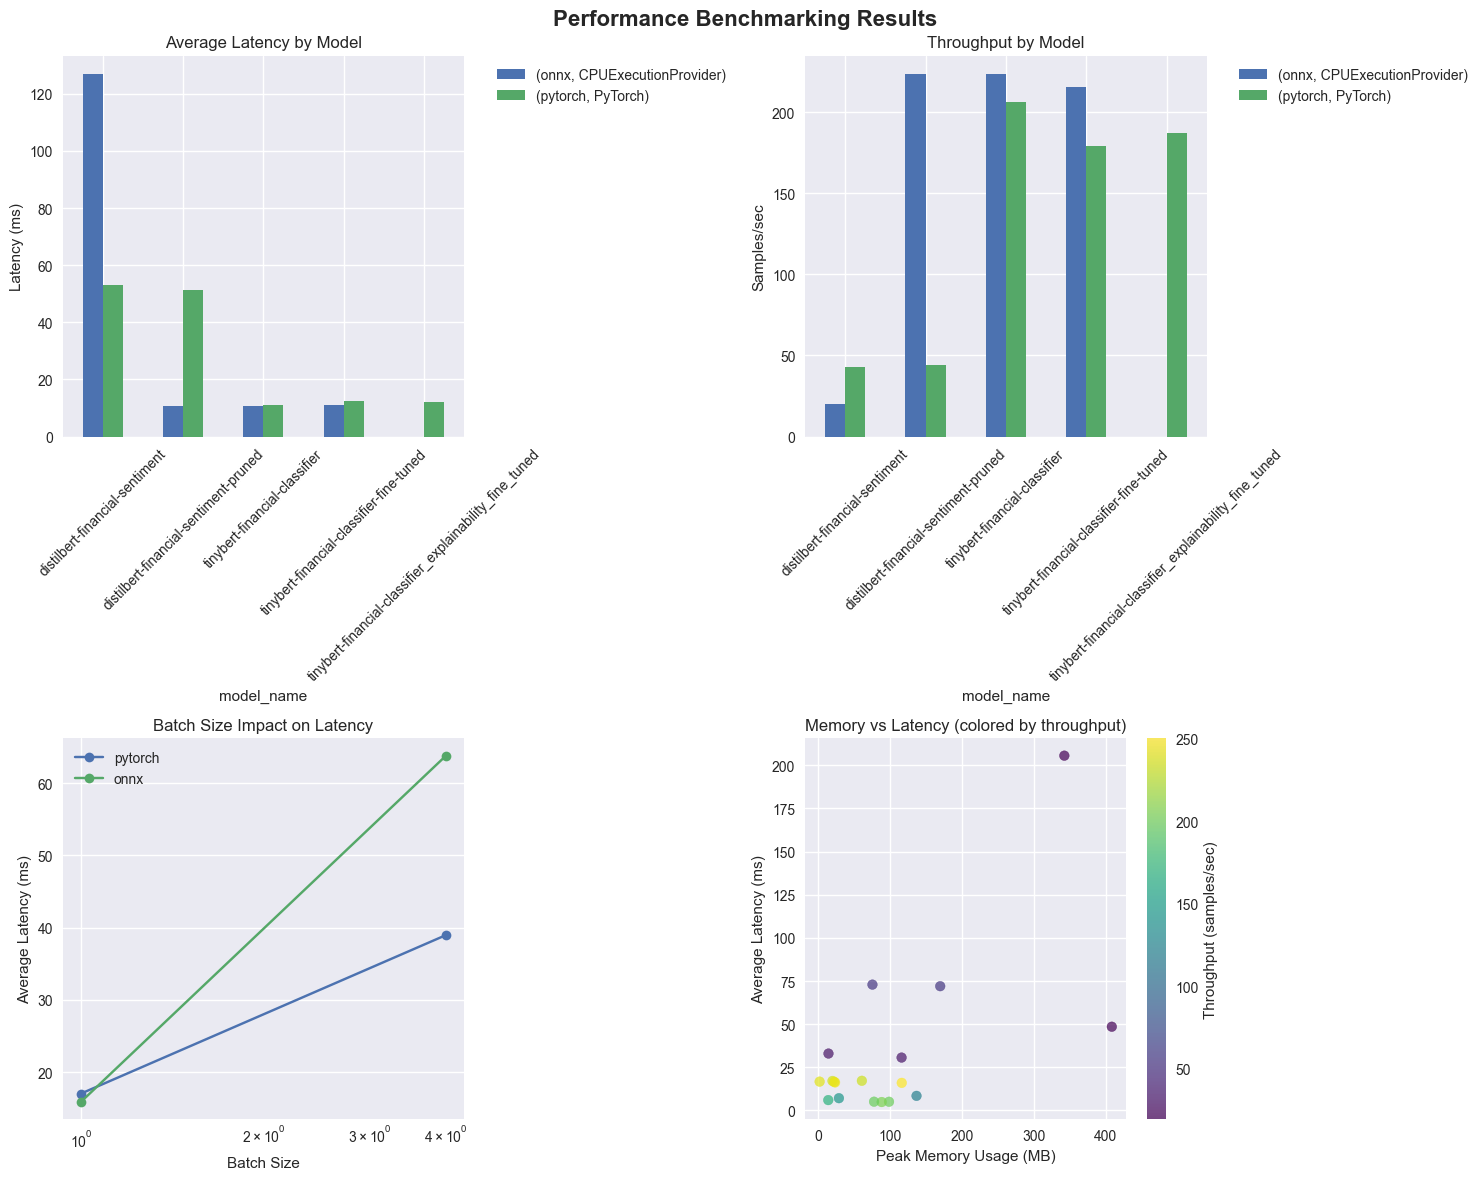

2025-08-18 10:51:27,681 - pipeline.benchmarking - INFO - Results visualization completed


In [6]:
# Results Analysis and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(f"\n📊 Results Analysis:")
print(f"{'='*80}")

# Create DataFrame from results with comprehensive metrics
results_data = []
for result in all_results:
    results_data.append({
        'model_name': result.model_name,
        'model_type': result.model_type,
        'provider': result.provider,
        'batch_size': result.batch_size,
        'avg_latency_ms': result.avg_latency_ms,
        'std_latency_ms': result.std_latency_ms,
        'min_latency_ms': result.min_latency_ms,
        'max_latency_ms': result.max_latency_ms,
        'p50_latency_ms': result.p50_latency_ms,
        'p95_latency_ms': result.p95_latency_ms,
        'p99_latency_ms': result.p99_latency_ms,
        'throughput_samples_per_sec': result.throughput_samples_per_sec,
        'peak_memory_mb': result.peak_memory_mb,
        'avg_memory_mb': result.avg_memory_mb,
        'memory_overhead_mb': result.memory_overhead_mb,
        'model_size_mb': result.model_size_mb,
        'accuracy': result.accuracy,
        'f1_score': result.f1_score,
        'validation_samples': result.validation_samples,
        # Calculated efficiency metrics
        'efficiency_score': result.throughput_samples_per_sec / result.model_size_mb if result.model_size_mb > 0 else None,
        'latency_stability': result.std_latency_ms / result.avg_latency_ms if result.avg_latency_ms > 0 and result.std_latency_ms else None,
        'memory_efficiency': result.throughput_samples_per_sec / result.peak_memory_mb if result.peak_memory_mb > 0 else None
    })

df_results = pd.DataFrame(results_data)
print(f"📋 Created results DataFrame with {len(df_results)} entries")

# Display best performers with enhanced analysis
print(f"\n🏆 Best Performers:")
print(f"{'='*60}")

# Best latency
best_latency_row = df_results.loc[df_results['avg_latency_ms'].idxmin()]
print(f"⚡ Lowest Latency: {best_latency_row['avg_latency_ms']:.2f}ms")
print(f"   📊 Model: {best_latency_row['model_name']}")
print(f"   🔧 Config: {best_latency_row['model_type']}-{best_latency_row['provider']}")
print(f"   📦 Batch: {best_latency_row['batch_size']}")
print(f"   🚀 Throughput: {best_latency_row['throughput_samples_per_sec']:.1f} samples/sec")
print(f"   💾 Memory: {best_latency_row['peak_memory_mb']:.1f}MB")
print(f"   📏 Model Size: {best_latency_row['model_size_mb']:.1f}MB")

# Best throughput
best_throughput_row = df_results.loc[df_results['throughput_samples_per_sec'].idxmax()]
print(f"\n🚀 Highest Throughput: {best_throughput_row['throughput_samples_per_sec']:.1f} samples/sec")
print(f"   📊 Model: {best_throughput_row['model_name']}")
print(f"   🔧 Config: {best_throughput_row['model_type']}-{best_throughput_row['provider']}")
print(f"   📦 Batch: {best_throughput_row['batch_size']}")
print(f"   ⚡ Latency: {best_throughput_row['avg_latency_ms']:.2f}ms")
print(f"   💾 Memory: {best_throughput_row['peak_memory_mb']:.1f}MB")
print(f"   📏 Model Size: {best_throughput_row['model_size_mb']:.1f}MB")

# Best efficiency (throughput per MB of model)
df_results['efficiency'] = df_results['throughput_samples_per_sec'] / df_results['model_size_mb']
best_efficiency_row = df_results.loc[df_results['efficiency'].idxmax()]
print(f"\n⚙️ Best Efficiency: {best_efficiency_row['efficiency']:.1f} samples/sec/MB")
print(f"   📊 Model: {best_efficiency_row['model_name']}")
print(f"   🔧 Config: {best_efficiency_row['model_type']}-{best_efficiency_row['provider']}")
print(f"   📦 Batch: {best_efficiency_row['batch_size']}")
print(f"   🚀 Throughput: {best_efficiency_row['throughput_samples_per_sec']:.1f} samples/sec")
print(f"   📏 Model Size: {best_efficiency_row['model_size_mb']:.1f}MB")

# Additional best performer metrics
# Best accuracy (if available)
if df_results['accuracy'].notna().any():
    best_accuracy_row = df_results.loc[df_results['accuracy'].idxmax()]
    print(f"\n🎯 Highest Accuracy: {best_accuracy_row['accuracy']:.4f}")
    print(f"   📊 Model: {best_accuracy_row['model_name']}")
    print(f"   🔧 Config: {best_accuracy_row['model_type']}-{best_accuracy_row['provider']}")
    print(f"   📦 Batch: {best_accuracy_row['batch_size']}")
    print(f"   ⚡ Latency: {best_accuracy_row['avg_latency_ms']:.2f}ms")
    if best_accuracy_row['f1_score']:
        print(f"   🎯 F1-Score: {best_accuracy_row['f1_score']:.4f}")

# Best stability (lowest coefficient of variation)
if df_results['latency_stability'].notna().any():
    best_stability_row = df_results.loc[df_results['latency_stability'].idxmin()]
    print(f"\n📊 Most Stable Latency: {best_stability_row['latency_stability']:.4f} CV")
    print(f"   📊 Model: {best_stability_row['model_name']}")
    print(f"   🔧 Config: {best_stability_row['model_type']}-{best_stability_row['provider']}")
    print(f"   📦 Batch: {best_stability_row['batch_size']}")
    print(f"   ⚡ Latency: {best_stability_row['avg_latency_ms']:.2f}ms ±{best_stability_row['std_latency_ms']:.2f}ms")

# Best memory efficiency
if df_results['memory_efficiency'].notna().any():
    best_mem_eff_row = df_results.loc[df_results['memory_efficiency'].idxmax()]
    print(f"\n💾 Best Memory Efficiency: {best_mem_eff_row['memory_efficiency']:.1f} samples/sec/MB")
    print(f"   📊 Model: {best_mem_eff_row['model_name']}")
    print(f"   🔧 Config: {best_mem_eff_row['model_type']}-{best_mem_eff_row['provider']}")
    print(f"   📦 Batch: {best_mem_eff_row['batch_size']}")
    print(f"   💾 Memory: {best_mem_eff_row['peak_memory_mb']:.1f}MB")

# Best accuracy (if available)
if df_results['accuracy'].notna().any():
    best_accuracy_row = df_results.loc[df_results['accuracy'].idxmax()]
    print(f"\n🎯 Highest Accuracy: {best_accuracy_row['accuracy']:.4f}")
    print(f"   Model: {best_accuracy_row['model_name']} ({best_accuracy_row['model_type']}-{best_accuracy_row['provider']})")
    print(f"   Batch: {best_accuracy_row['batch_size']}, Latency: {best_accuracy_row['avg_latency_ms']:.2f}ms")

# Performance by model type with enhanced metrics
print(f"\n📊 Performance by Model Type:")
print(f"{'='*60}")
type_summary = df_results.groupby('model_type').agg({
    'avg_latency_ms': ['mean', 'min', 'max', 'std'],
    'throughput_samples_per_sec': ['mean', 'min', 'max', 'std'],
    'peak_memory_mb': ['mean', 'min', 'max'],
    'model_size_mb': ['mean', 'min', 'max'],
    'accuracy': 'mean'
}).round(3)

for model_type in type_summary.index:
    print(f"\n🔥 {model_type.upper()}:")
    print(f"   ⚡ Latency: {type_summary.loc[model_type, ('avg_latency_ms', 'mean')]:.2f}ms ±{type_summary.loc[model_type, ('avg_latency_ms', 'std')]:.2f}ms")
    print(f"      Range: {type_summary.loc[model_type, ('avg_latency_ms', 'min')]:.2f}ms - {type_summary.loc[model_type, ('avg_latency_ms', 'max')]:.2f}ms")
    print(f"   🚀 Throughput: {type_summary.loc[model_type, ('throughput_samples_per_sec', 'mean')]:.1f} ±{type_summary.loc[model_type, ('throughput_samples_per_sec', 'std')]:.1f} samples/sec")
    print(f"      Range: {type_summary.loc[model_type, ('throughput_samples_per_sec', 'min')]:.1f} - {type_summary.loc[model_type, ('throughput_samples_per_sec', 'max')]:.1f} samples/sec")
    print(f"   💾 Memory: {type_summary.loc[model_type, ('peak_memory_mb', 'mean')]:.1f}MB avg ({type_summary.loc[model_type, ('peak_memory_mb', 'min')]:.1f}-{type_summary.loc[model_type, ('peak_memory_mb', 'max')]:.1f}MB)")
    print(f"   📏 Model Size: {type_summary.loc[model_type, ('model_size_mb', 'mean')]:.1f}MB avg ({type_summary.loc[model_type, ('model_size_mb', 'min')]:.1f}-{type_summary.loc[model_type, ('model_size_mb', 'max')]:.1f}MB)")
    if not pd.isna(type_summary.loc[model_type, ('accuracy', 'mean')]):
        print(f"   🎯 Accuracy: {type_summary.loc[model_type, ('accuracy', 'mean')]:.4f}")

# Enhanced Analysis with Fine-Tuning Comparisons
print(f"\n🔍 Fine-Tuning Impact Analysis:")
print(f"{'='*80}")

# Group models by their base architecture to detect fine-tuned versions
base_models = {}
fine_tuned_models = {}

for model_name in available_models.keys():
    # Clean model name to identify base architecture
    base_name = model_name
    is_fine_tuned = False
    
    # Common fine-tuning indicators
    fine_tune_indicators = ['fine_tuned', 'explainability', 'comparative', 'optimized', 'enhanced']
    
    for indicator in fine_tune_indicators:
        if indicator in model_name.lower():
            is_fine_tuned = True
            # Try to extract base model name
            base_name = model_name.lower().replace(f'_{indicator}', '').replace(f'-{indicator}', '')
            break
    
    if is_fine_tuned:
        if base_name not in fine_tuned_models:
            fine_tuned_models[base_name] = []
        fine_tuned_models[base_name].append(model_name)
    else:
        base_models[model_name] = model_name

# Identify model pairs for comparison
model_pairs = []
for base_name, fine_tuned_list in fine_tuned_models.items():
    # Look for corresponding base model
    base_model = None
    for base_model_name in base_models.keys():
        if base_name in base_model_name.lower() or any(part in base_model_name.lower() for part in base_name.split('-')):
            base_model = base_model_name
            break
    
    if base_model:
        for fine_tuned_model in fine_tuned_list:
            model_pairs.append((base_model, fine_tuned_model))

if model_pairs:
    print(f"🔗 Found {len(model_pairs)} base ↔ fine-tuned model pairs:")
    for base, fine_tuned in model_pairs:
        print(f"   📊 {base} → {fine_tuned}")
    
    # Analyze improvements
    print(f"\n📈 Fine-Tuning Performance Improvements:")
    print(f"{'='*60}")
    
    for base_model, fine_tuned_model in model_pairs:
        base_results = [r for r in all_results if r.model_name == base_model]
        fine_tuned_results = [r for r in all_results if r.model_name == fine_tuned_model]
        
        if base_results and fine_tuned_results:
            # Compare best performance from each model
            base_best = min(base_results, key=lambda x: x.avg_latency_ms)
            ft_best = min(fine_tuned_results, key=lambda x: x.avg_latency_ms)
            
            print(f"\n🔄 {base_model} vs {fine_tuned_model}:")
            
            # Latency comparison
            latency_improvement = ((base_best.avg_latency_ms - ft_best.avg_latency_ms) / base_best.avg_latency_ms) * 100
            if latency_improvement > 0:
                print(f"   ⚡ Latency: {latency_improvement:.1f}% faster ({base_best.avg_latency_ms:.2f}ms → {ft_best.avg_latency_ms:.2f}ms)")
            else:
                print(f"   ⚡ Latency: {abs(latency_improvement):.1f}% slower ({base_best.avg_latency_ms:.2f}ms → {ft_best.avg_latency_ms:.2f}ms)")
            
            # Throughput comparison
            throughput_improvement = ((ft_best.throughput_samples_per_sec - base_best.throughput_samples_per_sec) / base_best.throughput_samples_per_sec) * 100
            if throughput_improvement > 0:
                print(f"   🚀 Throughput: {throughput_improvement:.1f}% higher ({base_best.throughput_samples_per_sec:.1f} → {ft_best.throughput_samples_per_sec:.1f} samples/sec)")
            else:
                print(f"   🚀 Throughput: {abs(throughput_improvement):.1f}% lower ({base_best.throughput_samples_per_sec:.1f} → {ft_best.throughput_samples_per_sec:.1f} samples/sec)")
            
            # Accuracy comparison (if available)
            if base_best.accuracy is not None and ft_best.accuracy is not None:
                accuracy_improvement = ft_best.accuracy - base_best.accuracy
                if accuracy_improvement > 0:
                    print(f"   🎯 Accuracy: +{accuracy_improvement:.4f} improvement ({base_best.accuracy:.4f} → {ft_best.accuracy:.4f})")
                else:
                    print(f"   🎯 Accuracy: {accuracy_improvement:.4f} change ({base_best.accuracy:.4f} → {ft_best.accuracy:.4f})")
            
            # Memory comparison
            memory_change = ((ft_best.peak_memory_mb - base_best.peak_memory_mb) / base_best.peak_memory_mb) * 100
            if abs(memory_change) > 5:  # Only show if significant change
                if memory_change > 0:
                    print(f"   💾 Memory: {memory_change:.1f}% higher ({base_best.peak_memory_mb:.1f}MB → {ft_best.peak_memory_mb:.1f}MB)")
                else:
                    print(f"   💾 Memory: {abs(memory_change):.1f}% lower ({base_best.peak_memory_mb:.1f}MB → {ft_best.peak_memory_mb:.1f}MB)")
else:
    print("💡 No fine-tuned model pairs detected for comparison")
    print("   Run explainability or comparative fine-tuning notebooks to create fine-tuned models")

# Check for comparative fine-tuning results and display summary
comparative_results_files = list(Path("../results").glob("comparative_analysis_report_*.json")) if Path("../results").exists() else []
if comparative_results_files:
    latest_comparative = max(comparative_results_files, key=os.path.getctime)
    print(f"\n🔬 Latest Comparative Fine-Tuning Results:")
    print(f"{'='*50}")
    try:
        with open(latest_comparative, 'r') as f:
            comp_data = json.load(f)
        
        if 'summary' in comp_data:
            summary = comp_data['summary']
            if 'best_approach' in summary:
                print(f"   🏆 Best Approach: {summary['best_approach']}")
                print(f"   📈 Best Accuracy: {summary.get('best_accuracy', 'N/A')}")
            if 'most_efficient_approach' in summary:
                print(f"   ⚡ Most Efficient: {summary['most_efficient_approach']}")
        
        if 'recommendations' in comp_data:
            print(f"   💡 Key Recommendations:")
            for i, rec in enumerate(comp_data['recommendations'][:3], 1):  # Show top 3
                print(f"      {i}. {rec}")
    
    except Exception as e:
        print(f"   ⚠️ Could not load comparative results: {e}")

logger.info("Fine-tuning impact analysis completed")

# Create visualizations
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Performance Benchmarking Results', fontsize=16, fontweight='bold')

# 1. Latency comparison
ax1 = axes[0, 0]
df_pivot_latency = df_results.pivot_table(values='avg_latency_ms', index='model_name', 
                                          columns=['model_type', 'provider'], aggfunc='mean')
df_pivot_latency.plot(kind='bar', ax=ax1, rot=45)
ax1.set_title('Average Latency by Model')
ax1.set_ylabel('Latency (ms)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Throughput comparison  
ax2 = axes[0, 1]
df_pivot_throughput = df_results.pivot_table(values='throughput_samples_per_sec', index='model_name',
                                             columns=['model_type', 'provider'], aggfunc='mean')
df_pivot_throughput.plot(kind='bar', ax=ax2, rot=45)
ax2.set_title('Throughput by Model')
ax2.set_ylabel('Samples/sec')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Batch size impact on latency
ax3 = axes[1, 0]
for model_type in df_results['model_type'].unique():
    subset = df_results[df_results['model_type'] == model_type]
    batch_latency = subset.groupby('batch_size')['avg_latency_ms'].mean()
    ax3.plot(batch_latency.index, batch_latency.values, marker='o', label=model_type)
ax3.set_title('Batch Size Impact on Latency')
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('Average Latency (ms)')
ax3.legend()
ax3.set_xscale('log')

# 4. Memory usage vs performance
ax4 = axes[1, 1]
scatter = ax4.scatter(df_results['peak_memory_mb'], df_results['avg_latency_ms'], 
                      c=df_results['throughput_samples_per_sec'], cmap='viridis', alpha=0.7)
ax4.set_title('Memory vs Latency (colored by throughput)')
ax4.set_xlabel('Peak Memory Usage (MB)')
ax4.set_ylabel('Average Latency (ms)')
plt.colorbar(scatter, ax=ax4, label='Throughput (samples/sec)')

plt.tight_layout()
plt.show()

logger.info("Results visualization completed")

In [7]:
# Save Results
import json
from pathlib import Path

print(f"\n💾 Saving Results:")
print(f"{'='*80}")

# Create results directory
results_dir = Path("../results")  # Fixed: use Path directly instead of undefined base_path
results_dir.mkdir(exist_ok=True)

# Generate filename with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
base_filename = f"benchmark_results_generalized_{timestamp}"

# 1. Save CSV results
csv_path = results_dir / f"{base_filename}.csv"
df_results.to_csv(csv_path, index=False)
print(f"📊 CSV results saved: {csv_path}")

# 2. Save detailed JSON results
json_results = {
    'benchmark_summary': benchmark_summary,
    'detailed_results': [result.__dict__ for result in all_results],
    'performance_summary': {
        'best_latency': {
            'value': float(best_latency_row['avg_latency_ms']),
            'model': best_latency_row['model_name'],
            'config': f"{best_latency_row['model_type']}-{best_latency_row['provider']}",
            'batch_size': int(best_latency_row['batch_size'])
        },
        'best_throughput': {
            'value': float(best_throughput_row['throughput_samples_per_sec']),
            'model': best_throughput_row['model_name'],
            'config': f"{best_throughput_row['model_type']}-{best_throughput_row['provider']}",
            'batch_size': int(best_throughput_row['batch_size'])
        }
    }
}

# Add accuracy summary if available
if df_results['accuracy'].notna().any():
    json_results['performance_summary']['best_accuracy'] = {
        'value': float(best_accuracy_row['accuracy']),
        'model': best_accuracy_row['model_name'],
        'config': f"{best_accuracy_row['model_type']}-{best_accuracy_row['provider']}",
        'batch_size': int(best_accuracy_row['batch_size'])
    }

json_path = results_dir / f"{base_filename}.json"
with open(json_path, 'w') as f:
    json.dump(json_results, f, indent=2, default=str)
print(f"📋 JSON results saved: {json_path}")

# 3. Save performance summary report
report_path = results_dir / f"{base_filename}_summary.txt"
with open(report_path, 'w') as f:
    f.write("Performance Benchmarking Summary Report\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Configuration: {json_results['benchmark_summary']['configuration']}\n\n")
    
    f.write("Best Performers:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Lowest Latency: {best_latency_row['avg_latency_ms']:.2f}ms\n")
    f.write(f"  Model: {best_latency_row['model_name']} ({best_latency_row['model_type']}-{best_latency_row['provider']})\n")
    f.write(f"  Batch: {best_latency_row['batch_size']}\n\n")
    
    f.write(f"Highest Throughput: {best_throughput_row['throughput_samples_per_sec']:.1f} samples/sec\n")
    f.write(f"  Model: {best_throughput_row['model_name']} ({best_throughput_row['model_type']}-{best_throughput_row['provider']})\n")
    f.write(f"  Batch: {best_throughput_row['batch_size']}\n\n")
    
    if df_results['accuracy'].notna().any():
        f.write(f"Highest Accuracy: {best_accuracy_row['accuracy']:.4f}\n")
        f.write(f"  Model: {best_accuracy_row['model_name']} ({best_accuracy_row['model_type']}-{best_accuracy_row['provider']})\n")
        f.write(f"  Batch: {best_accuracy_row['batch_size']}\n\n")
    
    f.write("Performance by Model Type:\n")
    f.write("-" * 30 + "\n")
    for model_type in type_summary.index:
        f.write(f"{model_type.upper()}:\n")
        f.write(f"  Avg Latency: {type_summary.loc[model_type, ('avg_latency_ms', 'mean')]:.2f}ms\n")
        f.write(f"  Avg Throughput: {type_summary.loc[model_type, ('throughput_samples_per_sec', 'mean')]:.1f} samples/sec\n")
        if not pd.isna(type_summary.loc[model_type, ('accuracy', 'mean')]):
            f.write(f"  Avg Accuracy: {type_summary.loc[model_type, ('accuracy', 'mean')]:.4f}\n")
        f.write("\n")

print(f"📄 Summary report saved: {report_path}")

# 4. Save plot
plot_path = results_dir / f"{base_filename}_plots.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"📈 Plots saved: {plot_path}")

# 5. Update state manager with latest results (if available)
if pipeline_available and state:
    try:
        state.save_state('benchmark_results', {
            'latest_run': {
                'timestamp': timestamp,
                'csv_path': str(csv_path),
                'json_path': str(json_path),
                'report_path': str(report_path),
                'plot_path': str(plot_path)
            },
            'summary': json_results['performance_summary'],
            'models_benchmarked': list(available_models.keys()),
            'successful_benchmarks': successful_benchmarks,
            'total_benchmarks': total_benchmarks
        })
        print(f"💾 State updated with benchmark results")
    except Exception as e:
        logger.warning(f"Failed to update state: {e}")
else:
    print(f"💡 Pipeline state not available - results saved locally only")

# Display completion summary
print(f"\n🎉 Benchmarking Complete!")
print(f"{'='*80}")
print(f"📊 Results available in: {results_dir}")
print(f"📈 CSV: {csv_path.name}")
print(f"📋 JSON: {json_path.name}")
print(f"📄 Report: {report_path.name}")
print(f"🖼️ Plots: {plot_path.name}")

logger.info(f"Comprehensive benchmarking completed successfully. Results saved to {results_dir}")
print(f"\n✅ All benchmarking tasks completed successfully!")

2025-08-18 10:51:27,781 - pipeline.benchmarking - WARNING - Failed to update state: StateManager.save_state() takes 1 positional argument but 3 were given
2025-08-18 10:51:27,782 - pipeline.benchmarking - INFO - Comprehensive benchmarking completed successfully. Results saved to ../results
2025-08-18 10:51:27,782 - pipeline.benchmarking - INFO - Comprehensive benchmarking completed successfully. Results saved to ../results



💾 Saving Results:
📊 CSV results saved: ../results/benchmark_results_generalized_20250818_105127.csv
📋 JSON results saved: ../results/benchmark_results_generalized_20250818_105127.json
📄 Summary report saved: ../results/benchmark_results_generalized_20250818_105127_summary.txt
📈 Plots saved: ../results/benchmark_results_generalized_20250818_105127_plots.png

🎉 Benchmarking Complete!
📊 Results available in: ../results
📈 CSV: benchmark_results_generalized_20250818_105127.csv
📋 JSON: benchmark_results_generalized_20250818_105127.json
📄 Report: benchmark_results_generalized_20250818_105127_summary.txt
🖼️ Plots: benchmark_results_generalized_20250818_105127_plots.png

✅ All benchmarking tasks completed successfully!


<Figure size 800x550 with 0 Axes>